In [1]:
import matplotlib
import glob
import numpy as np
import matplotlib.pyplot as plt
import PIL
from IPython.display import Image 
import io
import os
import IPython
from sklearn.feature_extraction import image as sklearnimage
from sklearn.decomposition import FastICA
import matplotlib.cm as cm
import math

/Users/yilingtung/miniconda3/envs/py36/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
# This whitening code is from https://gist.github.com/joelouismarino/ce239b5601fff2698895f48003f7464b
def whiten(X, method='zca'):
    """
    Whitens the input matrix X using specified whitening method.
    Inputs:
        X:      Input data matrix with data examples along the first dimension
        method: Whitening method. Must be one of 'zca', 'zca_cor', 'pca',
                'pca_cor', or 'cholesky'.
    """
    X = X.reshape((-1, np.prod(X.shape[1:])))
    X_centered = X - np.mean(X, axis=0)
    Sigma = np.dot(X_centered.T, X_centered) / X_centered.shape[0]
    W = None
    
    if method in ['zca', 'pca', 'cholesky']:
        U, Lambda, _ = np.linalg.svd(Sigma)
        if method == 'zca':
            W = np.dot(U, np.dot(np.diag(1.0 / np.sqrt(Lambda + 1e-5)), U.T))
        elif method =='pca':
            W = np.dot(np.diag(1.0 / np.sqrt(Lambda + 1e-5)), U.T)
        elif method == 'cholesky':
            W = np.linalg.cholesky(np.dot(U, np.dot(np.diag(1.0 / (Lambda + 1e-5)), U.T))).T
    elif method in ['zca_cor', 'pca_cor']:
        V_sqrt = np.diag(np.std(X, axis=0))
        P = np.dot(np.dot(np.linalg.inv(V_sqrt), Sigma), np.linalg.inv(V_sqrt))
        G, Theta, _ = np.linalg.svd(P)
        if method == 'zca_cor':
            W = np.dot(np.dot(G, np.dot(np.diag(1.0 / np.sqrt(Theta + 1e-5)), G.T)), V_sqrt)
        elif method == 'pca_cor':
            W = np.dot(np.dot(np.diag(1.0/np.sqrt(Theta + 1e-5)), G.T), V_sqrt)
    else:
        raise Exception('Whitening method not found.')

    return np.dot(X_centered, W.T)

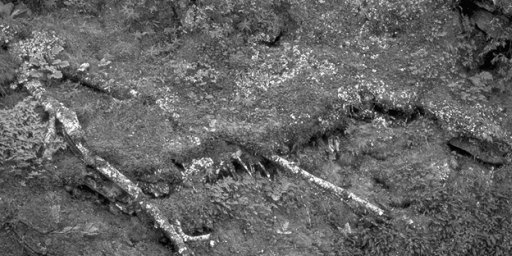

In [3]:
# The images are from http://research.ics.aalto.fi/ica/imageica/
np.random.seed(0)
data_dir = 'matlabData/'
images = [PIL.Image.open(f) for f in glob.glob(data_dir + '*.tiff')]
images[0]

In [4]:
image_data = [np.array(i) for i in images]
for data in image_data:
    print(data.shape)

(256, 512)
(256, 512)
(256, 512)
(512, 256)
(512, 256)
(256, 512)
(256, 512)
(512, 256)
(256, 512)
(256, 512)
(256, 512)
(256, 512)
(512, 256)


In [5]:
patch_size = (16, 16)
num_samples = 50000
num_samples -= 50000%len(images)

In [6]:
# Get image patch samples
X = np.zeros((num_samples, patch_size[0] * patch_size[1]))
patches = 0
for i in range(len(image_data)):
    num_patches = int(num_samples/len(image_data))
    extracted_patches = sklearnimage.extract_patches_2d(image_data[i], patch_size, num_patches)
    extracted_patches = extracted_patches.reshape(num_patches, patch_size[0] * patch_size[1])
    X[patches:patches + num_patches, :] = extracted_patches
    patches += num_patches

print(X.shape)

(49998, 256)


/Users/yilingtung/miniconda3/envs/py36/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


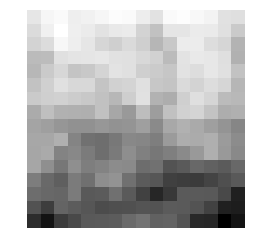

In [7]:
# Mean image patch
meanImagePatch = np.mean(X, axis=0)
plt.imshow(meanImagePatch.reshape(patch_size),cmap = cm.Greys_r)
plt.axis('off')
plt.savefig('meanImagePatch.png')
plt.show()


In [8]:
# ZCA whitening
X_zca_whitened = whiten(X, method='zca')
X_pca_whitened = whiten(X, method='pca')

X_centered = X - meanImagePatch
print(meanImagePatch)
print(X[0])
print(X_centered[0])

[104.15820633 104.29555182 104.33881355 104.21522861 104.24426977
 104.29523181 104.35907436 104.33093324 104.20396816 104.12664507
 104.33553342 104.36769471 104.31207248 104.25729029 104.12564503
 104.10948438 104.08592344 104.2274891  104.38523541 104.22262891
 104.19344774 104.13194528 104.17628705 104.19458778 104.03530141
 103.93385735 104.15310612 104.14800592 104.19122765 104.18786751
 104.12114485 103.98523941 104.03270131 104.0900836  104.30231209
 104.2125085  104.15986639 104.049882   104.01070043 104.08024321
 104.01048042 103.87833513 103.9700588  104.19784791 104.19914797
 104.09948398 104.04774191 103.86815473 103.89903596 103.90515621
 104.11162446 104.14438578 104.14842594 104.1624265  104.12350494
 104.11326453 104.06584263 104.02574103 103.8975559  104.1374255
 104.17786711 104.16970679 104.11090444 103.86131445 103.88599544
 103.98389936 104.0550622  103.95119805 103.96901876 104.04148166
 104.13762551 104.11842474 104.01594064 103.99063963 103.96159846
 104.134725

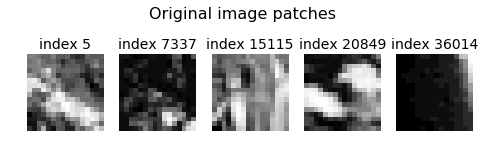

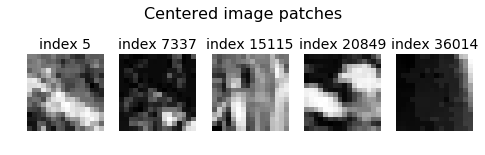

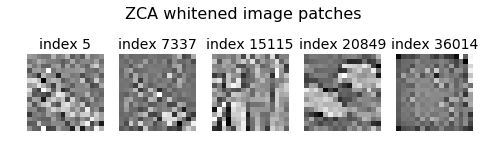

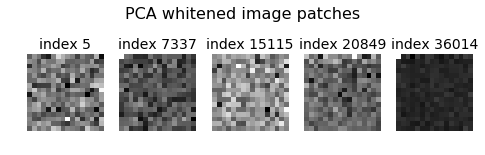

In [9]:
np.random.seed(1)
numPatchesToPlot = 5
patchSamples = np.random.rand(numPatchesToPlot)*(X.shape[0]-1)
patchSamples.sort()
patchSamples = [int(i) for i in patchSamples]
patchSamples

boxSize = (8,2.5)
fig_original, axarr_original = plt.subplots(1, numPatchesToPlot, figsize=boxSize)
fig_centered, axarr_centered = plt.subplots(1, numPatchesToPlot, figsize=boxSize)
fig_zca, axarr_zca = plt.subplots(1, numPatchesToPlot, figsize=boxSize)
fig_pca, axarr_pca = plt.subplots(1, numPatchesToPlot, figsize=boxSize)

for i in range(numPatchesToPlot):
    idx = patchSamples[i]
    axarr_original[i].set_title("index {}".format(idx),fontsize=14)
    axarr_original[i].axis('off')
    axarr_original[i].imshow(X[idx].reshape(patch_size),cmap = cm.Greys_r)
    
    axarr_centered[i].set_title("index {}".format(idx),fontsize=14)
    axarr_centered[i].axis('off')
    axarr_centered[i].imshow(X_centered[idx].reshape(patch_size),cmap = cm.Greys_r)
    
    axarr_zca[i].set_title("index {}".format(idx),fontsize=14)
    axarr_zca[i].axis('off')
    axarr_zca[i].imshow(X_zca_whitened[idx].reshape(patch_size),cmap = cm.Greys_r)
    
    axarr_pca[i].set_title("index {}".format(idx),fontsize=14)
    axarr_pca[i].axis('off')
    axarr_pca[i].imshow(X_pca_whitened[idx].reshape(patch_size),cmap = cm.Greys_r)
    
 
fig_original.suptitle("Original image patches",fontsize=16)
fig_centered.suptitle("Centered image patches",fontsize=16)
fig_zca.suptitle("ZCA whitened image patches",fontsize=16)
fig_pca.suptitle("PCA whitened image patches",fontsize=16)
plt.savefig('whitening.png')
plt.show()

In [10]:
ica = FastICA(whiten=False)
S_ = ica.fit_transform(X_zca_whitened)
W_ = ica.components_
A_ = ica.mixing_

/Users/yilingtung/miniconda3/envs/py36/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


In [11]:
A_.shape

(256, 256)

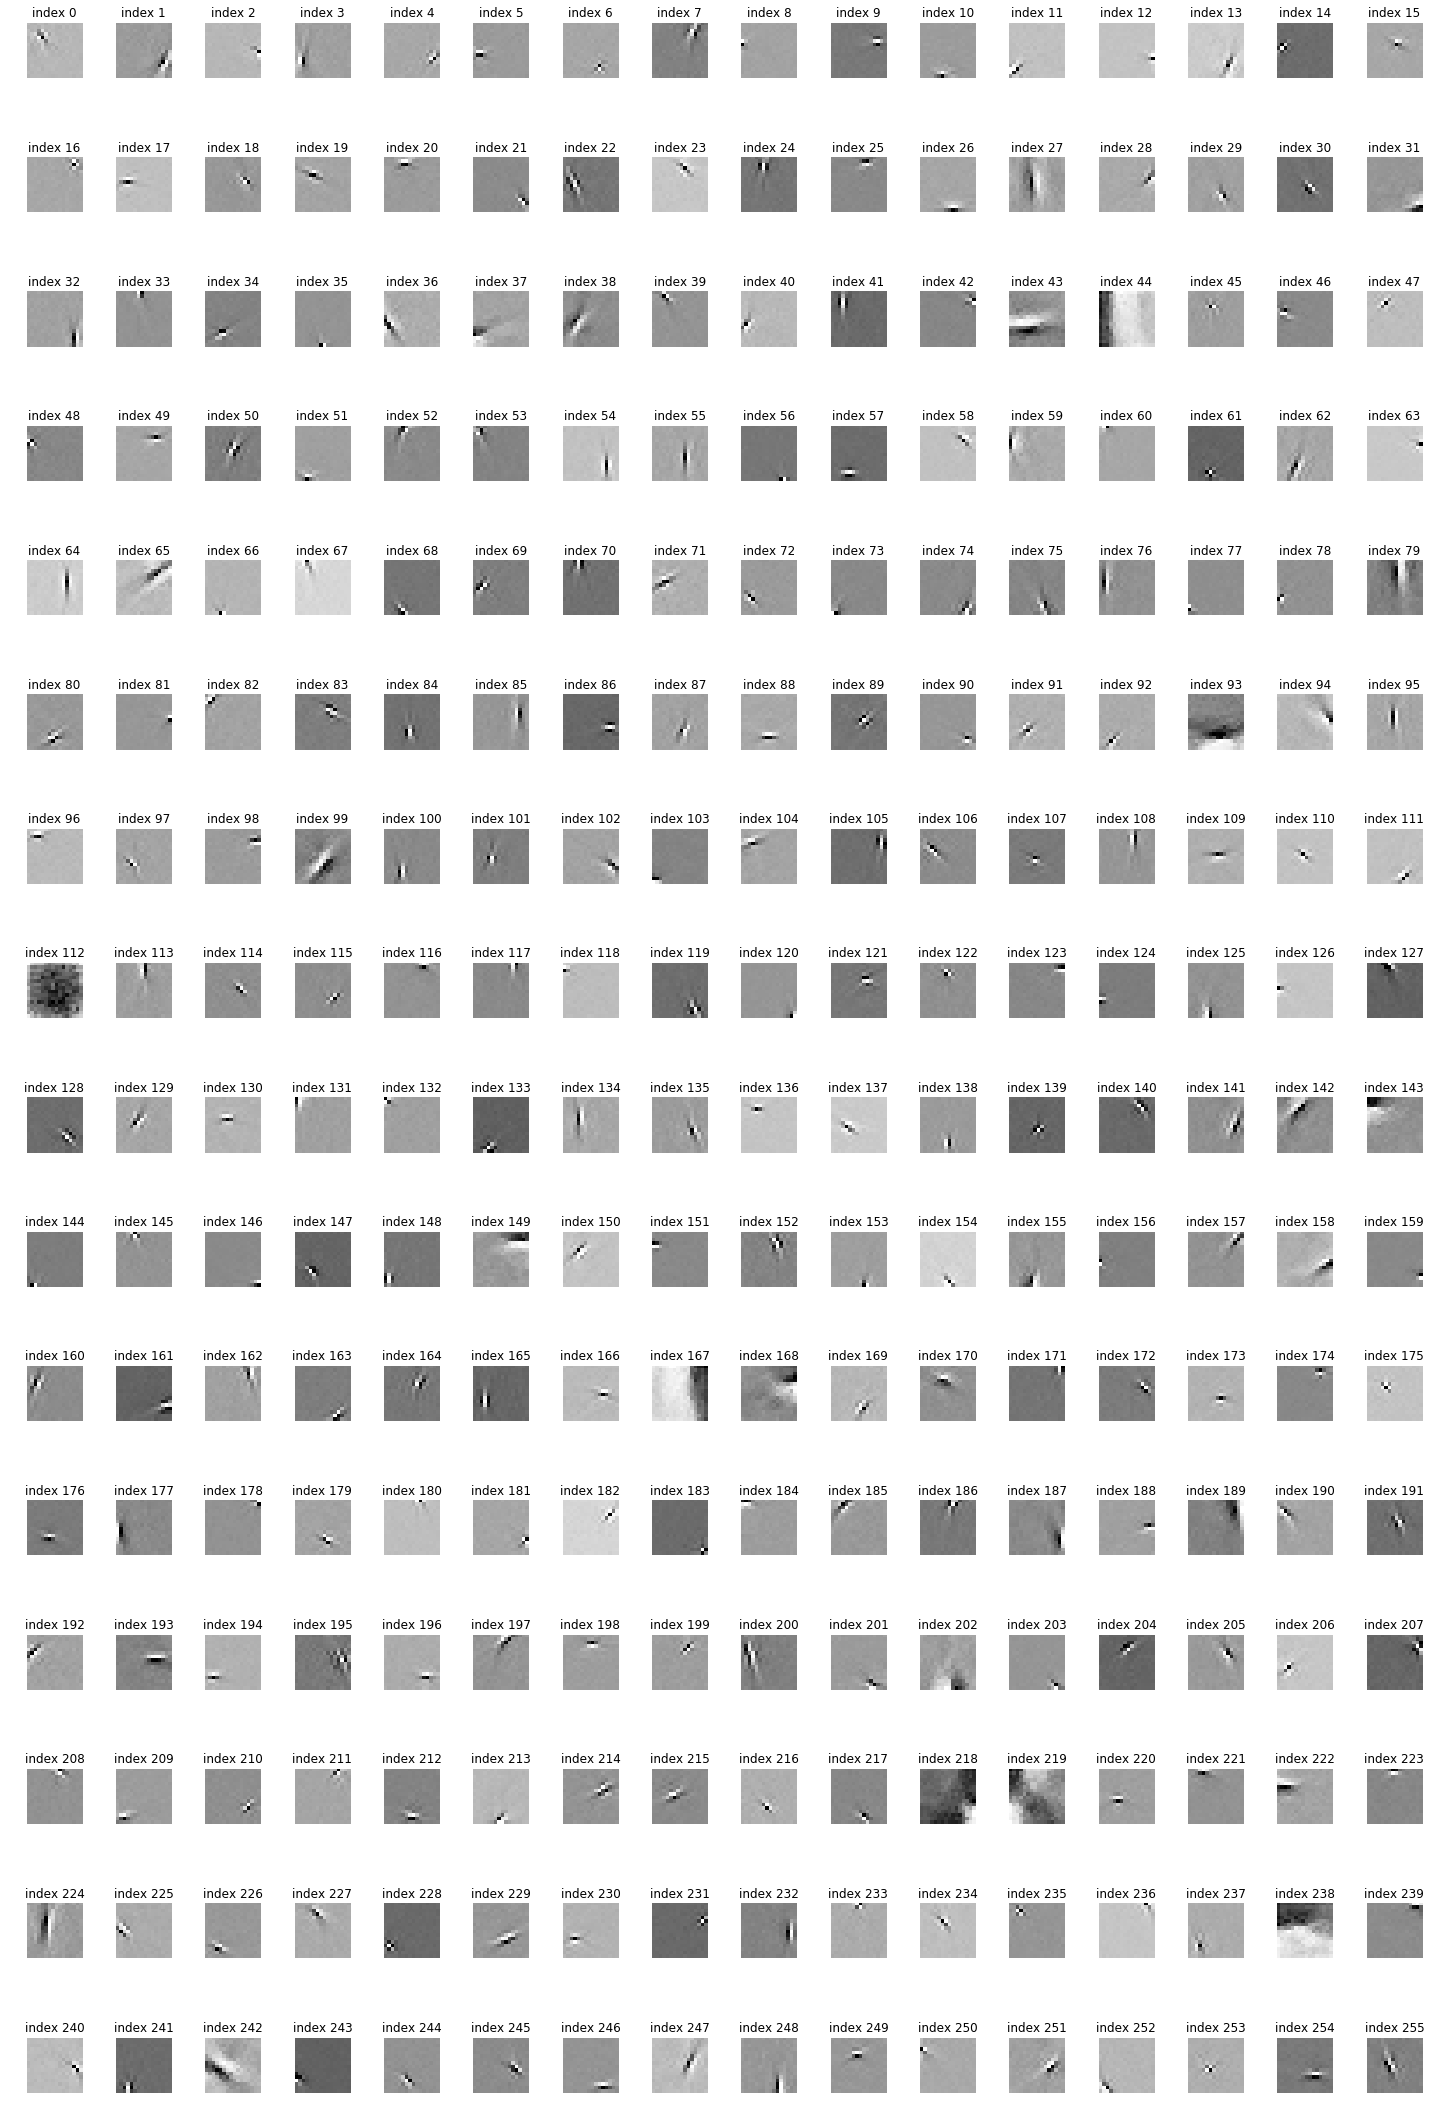

In [12]:
W_ = ica.components_
W_grayscale = ((W_ - W_.min()) / (W_.max()-W_.min())) * 255
gridlength = 16
fig_e, axarr_e = plt.subplots(gridlength, gridlength, figsize=(20, 30))
for i in range(gridlength*gridlength):
    row = i//gridlength
    col = i%gridlength
    f = W_[i]
    axarr_e[row,col].imshow(f.reshape(16,16), cmap = cm.Greys_r)
    axarr_e[row,col].set_title("index {}".format(i))
    axarr_e[row,col].axis('off')
fig_e.subplots_adjust(wspace=-.2, hspace=-.1)
plt.tight_layout() 
plt.show()

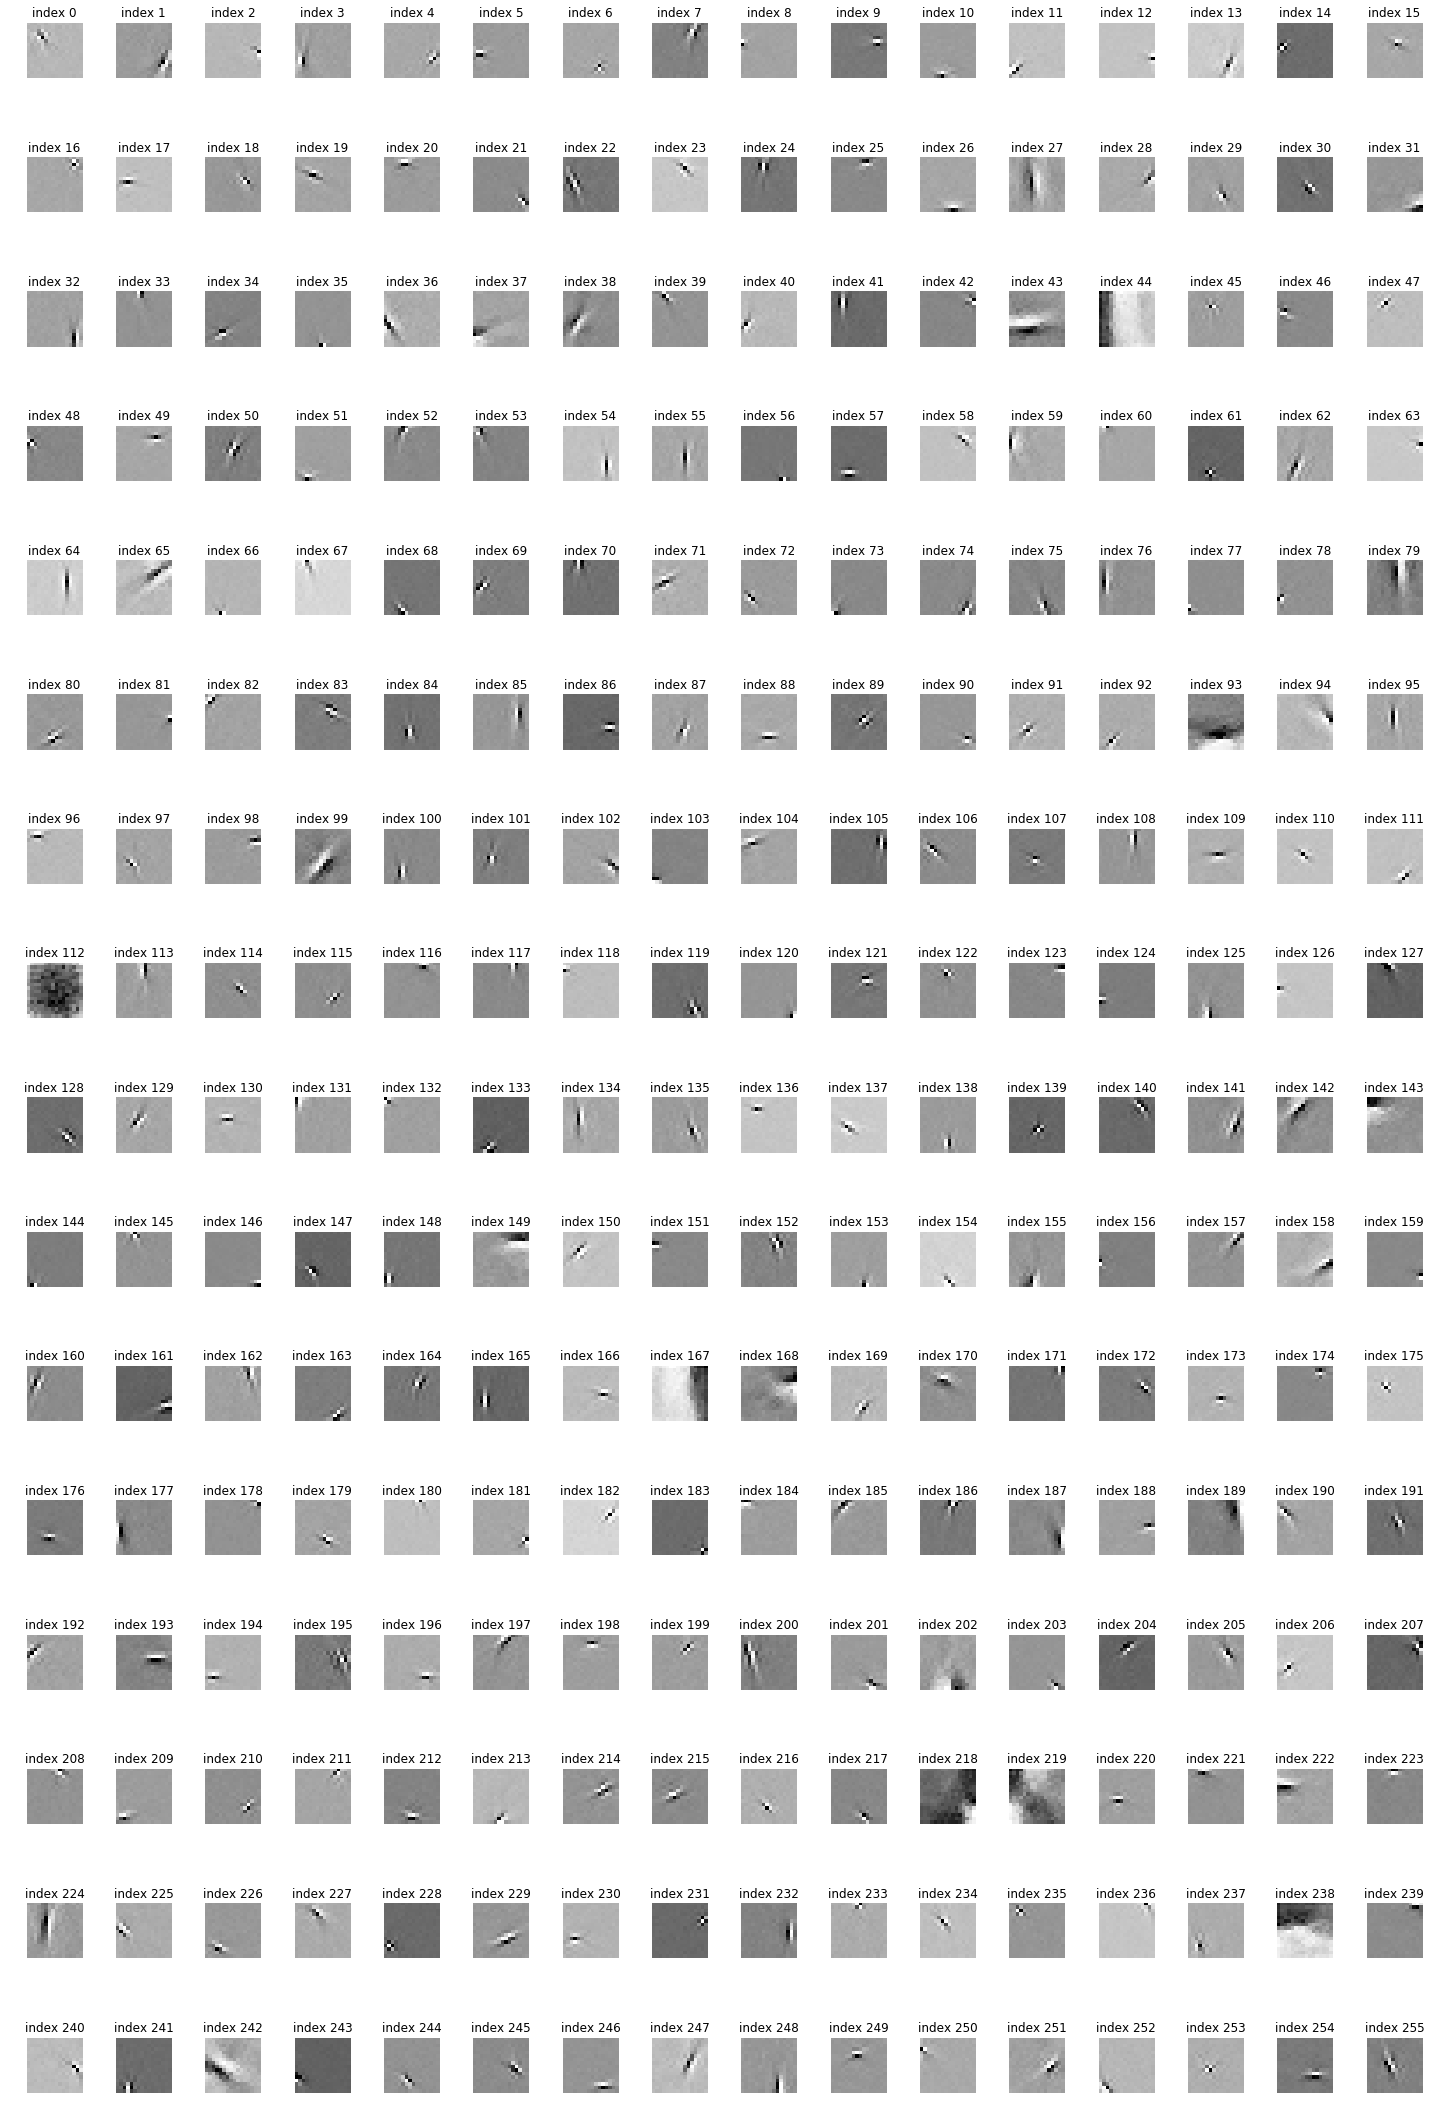

In [13]:
W_ = A_.T
W_grayscale = ((W_ - W_.min()) / (W_.max()-W_.min())) * 255
gridlength = 16
fig_e, axarr_e = plt.subplots(gridlength, gridlength, figsize=(20, 30))
for i in range(gridlength*gridlength):
    row = i//gridlength
    col = i%gridlength
    f = W_[i]
    axarr_e[row,col].imshow(f.reshape(16,16), cmap = cm.Greys_r)
    axarr_e[row,col].set_title("index {}".format(i))
    axarr_e[row,col].axis('off')
fig_e.subplots_adjust(wspace=-.2, hspace=-.1)
plt.tight_layout() 
plt.savefig("features.png")
plt.show()

In [14]:
# Get image patch samples
big_patch_size = (32, 32)
num_samples = 50000
num_samples -= num_samples%len(images)

X = np.zeros((num_samples, big_patch_size[0] * big_patch_size[1]))
patches = 0
for i in range(len(image_data)):
    num_patches = int(num_samples/len(image_data))
    extracted_patches = sklearnimage.extract_patches_2d(image_data[i], big_patch_size, num_patches)
    extracted_patches = extracted_patches.reshape(num_patches, big_patch_size[0] * big_patch_size[1])
    X[patches:patches + num_patches, :] = extracted_patches
    patches += num_patches

print(X.shape)

/Users/yilingtung/miniconda3/envs/py36/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


(49998, 1024)


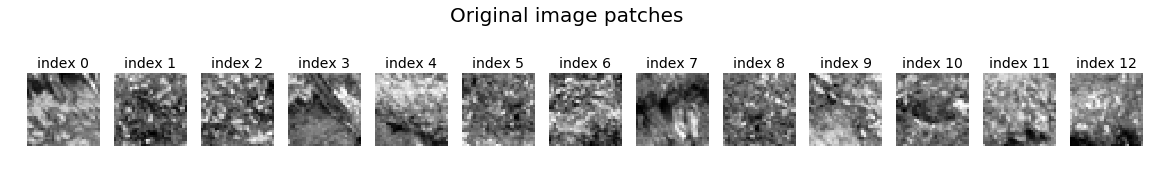

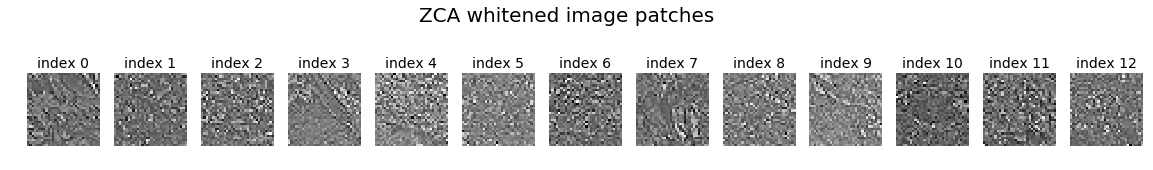

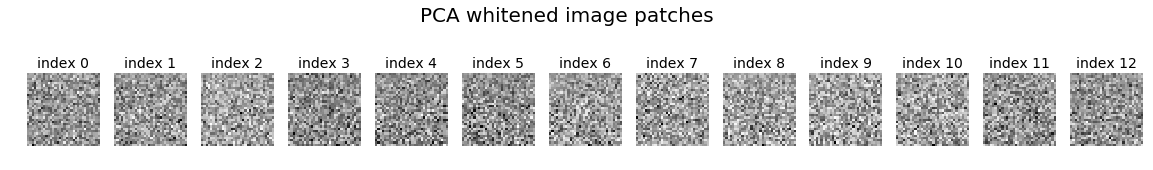

In [15]:
# ZCA whitening
X_zca_whitened = whiten(X, method='zca')
X_pca_whitened = whiten(X, method='pca')

numPatchesToPlot = 13
boxSize = (20,3)
fig_original, axarr_original = plt.subplots(1, numPatchesToPlot, figsize=boxSize)
fig_zca, axarr_zca = plt.subplots(1, numPatchesToPlot, figsize=boxSize)
fig_pca, axarr_pca = plt.subplots(1, numPatchesToPlot, figsize=boxSize)
for i in range(numPatchesToPlot):
    axarr_original[i].set_title("index {}".format(i),fontsize=14)
    axarr_original[i].axis('off')
    axarr_original[i].imshow(X[i].reshape(big_patch_size),cmap = cm.Greys_r)
    
    axarr_zca[i].set_title("index {}".format(i),fontsize=14)
    axarr_zca[i].axis('off')
    axarr_zca[i].imshow(X_zca_whitened[i].reshape(big_patch_size),cmap = cm.Greys_r)
    
    axarr_pca[i].set_title("index {}".format(i),fontsize=14)
    axarr_pca[i].axis('off')
    axarr_pca[i].imshow(X_pca_whitened[i].reshape(big_patch_size),cmap = cm.Greys_r)
 
fig_original.suptitle("Original image patches",fontsize=20)
fig_zca.suptitle("ZCA whitened image patches",fontsize=20)
fig_pca.suptitle("PCA whitened image patches",fontsize=20)
plt.show()